In [28]:
import sys, os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install --upgrade typing_extensions
# !pip install openai
from openai import OpenAI
from dotenv import load_dotenv
from pathlib import Path
from src.data.raw_data_inspection import inspect_raw_data
from src.data.create_dataset import split_and_save
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import format_case_row, FewShotExample, build_fewshot_block, call_gpt_batch, stratified_sample_U
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import format_case_row, FewShotExample, build_fewshot_block, call_gpt_batch, stratified_sample_U
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data" / "processed"


In [29]:
RAW_CSV = PROJECT_ROOT / "data" / "raw" / "ds_whole.csv"
df = inspect_raw_data(RAW_CSV)
split_and_save(test_size=0.2, calib_size=0.2, random_state=42)

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RL                499 non-null    object 
 1   glaucoma          499 non-null    int64  
 2   age               499 non-null    int64  
 3   ocular_pressure   499 non-null    int64  
 4   MD                499 non-null    float64
 5   PSD               499 non-null    float64
 6   GHT               499 non-null    int64  
 7   cornea_thickness  499 non-null    int64  
 8   RNFL4.mean        499 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 35.2+ KB
None 

Missing Values Info
RL                  0
glaucoma            0
age                 0
ocular_pressure     0
MD                  0
PSD                 0
GHT                 0
cornea_thickness    0
RNFL4.mean          0
dtype: int64 

Basic Summary
         RL    glaucoma         age  ocular_pressure

In [30]:
train = pd.read_pickle(DATA_DIR / "train.pkl")
calib = pd.read_pickle(DATA_DIR / "calib.pkl")
test  = pd.read_pickle(DATA_DIR / "test.pkl")

pipe = train_logreg(train)

m_test, proba_test, yhat_test = evaluate(pipe, test, threshold=0.5)
FN_baseline = m_test["FN"]
print("Baseline metrics:", m_test)

Baseline metrics: {'ACC': 0.93, 'AUROC': 0.9842910293509715, 'TP': 53, 'FP': 1, 'TN': 40, 'FN': 6, 'RECALL': 0.8983050847457474, 'PRECISION': 0.9814814814814633, 'F1': 0.9380530973451244}


In [31]:
alphas = [0.05, 0.10, 0.15, 0.20, 0.30]
records = []

for a in alphas:
    q = calibrate_threshold(pipe, calib, alpha=a)
    out = cp_partition(pipe, test, q)
    cnts = summarize_counts(out["y_true"], out["y_pred"], out["region"])
    cnts["alpha"] = a
    cnts["q"] = q
    cnts["FN_baseline"] = FN_baseline
    records.append(cnts)

df_cp = pd.DataFrame(records)
df_cp

,TP_confident,FN_confident,FP_confident,TN_confident,U_pos,U_neg,C_size,U_size,alpha,q,FN_baseline
0,53,6,1,40,0,0,100,0,0.05,0.685680,6
1,53,6,1,40,0,0,100,0,0.10,0.528078,6
2,49,3,1,39,7,1,92,8,0.15,0.393180,6
3,47,1,0,34,11,7,82,18,0.20,0.209705,6
4,45,1,0,26,13,15,72,28,0.30,0.109941,6


In [32]:
def new_errors(FN_confident, FP_confident, U_pos, U_neg, s, t):
    FN_new = FN_confident + (1 - s) * U_pos
    FP_new = FP_confident + (1 - t) * U_neg
    return FN_new, FP_new

df_cp["FN_oracle"], df_cp["FP_oracle"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=1.0, t=1.0), axis=1))

s_gpt, t_gpt = 0.9, 0.85
df_cp["FN_gpt"], df_cp["FP_gpt"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s_gpt, t=t_gpt), axis=1))

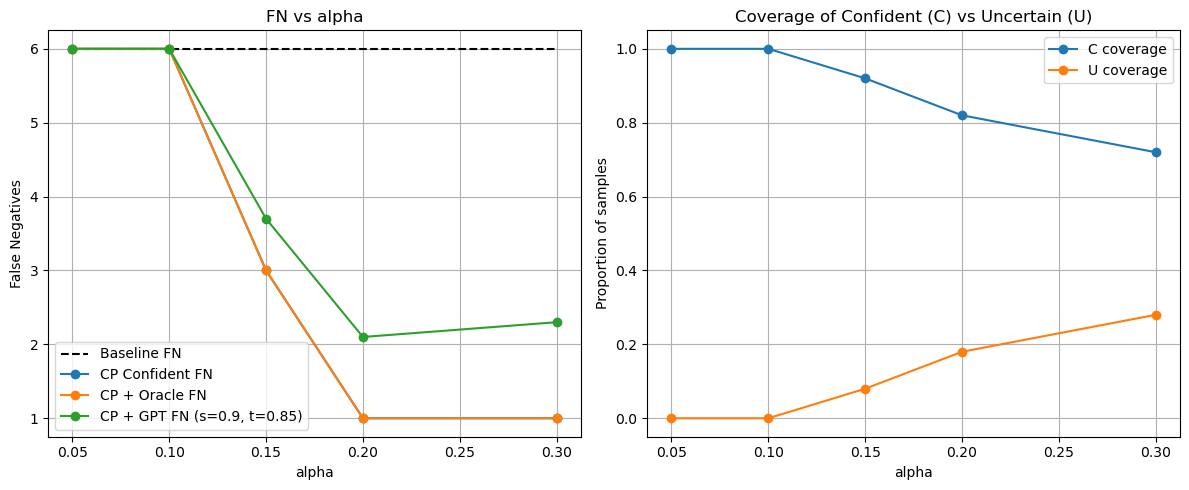

In [33]:
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def new_errors(FN_confident, FP_confident, U_pos, U_neg, s, t):
    FN_new = FN_confident + (1 - s) * U_pos
    FP_new = FP_confident + (1 - t) * U_neg
    return FN_new, FP_new

df_cp["FN_oracle"], df_cp["FP_oracle"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=1.0, t=1.0), axis=1))

s_gpt, t_gpt = 0.9, 0.85
df_cp["FN_gpt"], df_cp["FP_gpt"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg, s=s_gpt, t=t_gpt), axis=1))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(df_cp["alpha"], df_cp["FN_baseline"], "--", label="Baseline FN", color="black")
axes[0].plot(df_cp["alpha"], df_cp["FN_confident"], "o-", label="CP Confident FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_oracle"], "o-", label="CP + Oracle FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_gpt"], "o-", label=f"CP + GPT FN (s={s_gpt}, t={t_gpt})")
axes[0].set_xlabel("alpha")
axes[0].set_ylabel("False Negatives")
axes[0].set_title("FN vs alpha")
axes[0].legend()
axes[0].grid(True)

total = len(test)
axes[1].plot(df_cp["alpha"], df_cp["C_size"]/total, "o-", label="C coverage")
axes[1].plot(df_cp["alpha"], df_cp["U_size"]/total, "o-", label="U coverage")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("Proportion of samples")
axes[1].set_title("Coverage of Confident (C) vs Uncertain (U)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

out_path = FIG_DIR / "cp_fn_coverage.png"
plt.savefig(out_path, dpi=200)
plt.show()

In [34]:
%load_ext autoreload
%autoreload 2

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
sys.path.append(str(PROJECT_ROOT))


DATA_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR  = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
out = cp_partition(pipe, test, q)
test_u = test[out["region"] == "U"].copy()
print("Test-U size:", len(test_u), "\nLabel counts:\n", test_u["glaucoma"].value_counts())

out_calib = cp_partition(pipe, calib, q)
calib_u = calib[out_calib["region"] == "U"].copy()
dev_u, _ = stratified_sample_U(calib_u, n_per_class=4, seed=42)

fewshots = []
for _, row in dev_u.iterrows():
    case_card = format_case_row(row)
    fewshots.append(FewShotExample(case_card=case_card, label=int(row["glaucoma"])))
fewshot_block = build_fewshot_block(fewshots)
print(f"Few-shot examples: {len(fewshots)}")

Test-U size: 28 
Label counts:
 glaucoma
0    15
1    13
Name: count, dtype: int64
Few-shot examples: 8


In [37]:
def gpt_multiple_runs(client, model_name, test_u, fewshot_block, n_runs=5, temperature=0.3):
    case_cards = [format_case_row(r) for _, r in test_u.iterrows()]
    all_preds = []
    for r in trange(n_runs, desc="GPT runs"):
        gpt_out = call_gpt_batch(client, model=model_name, cases=case_cards,
                                 fewshot_block=fewshot_block, temperature=temperature)
        preds = []
        for item in gpt_out:
            try:
                preds.append(int(item["prediction"]))
            except:
                preds.append(None)
        all_preds.append(preds)
    return np.array(all_preds)

def evaluate_gpt_runs(all_preds, y_true):
    y_true = np.asarray(y_true).astype(int)
    mask_valid = ~np.any(all_preds==None, axis=0)
    y_true_eval = y_true[mask_valid]
    preds_eval = all_preds[:, mask_valid].astype(int)

    s_list, t_list = [], []
    for run in preds_eval:
        cm = confusion_from_preds(y_true_eval, run)
        s, t = sensitivity_specificity(cm)
        s_list.append(s); t_list.append(t)
    return np.array(s_list), np.array(t_list), y_true_eval, preds_eval


def bootstrap_ci(preds_eval, y_true_eval, n_boot=1000, alpha=0.05):
    rng = np.random.default_rng(42)
    n = len(y_true_eval)
    s_boot, t_boot = [], []
    for _ in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        y_b = y_true_eval[idx]
        pred_b = (preds_eval[:, idx].mean(axis=0) >= 0.5).astype(int)
        cm = confusion_from_preds(y_b, pred_b)
        s, t = sensitivity_specificity(cm)
        s_boot.append(s); t_boot.append(t)
    low, high = alpha/2, 1-alpha/2
    s_ci = (np.nanpercentile(s_boot, low*100), np.nanpercentile(s_boot, high*100))
    t_ci = (np.nanpercentile(t_boot, low*100), np.nanpercentile(t_boot, high*100))
    return s_ci, t_ci

In [38]:
all_preds = gpt_multiple_runs(client, "gpt-4o-mini", test_u, fewshot_block, n_runs=5, temperature=0.2)

s_list, t_list, y_true_eval, preds_eval = evaluate_gpt_runs(all_preds, test_u["glaucoma"].values)
print("Run-wise sensitivity:", s_list)
print("Run-wise specificity:", t_list)
print("Mean s:", s_list.mean(), "±", s_list.std())
print("Mean t:", t_list.mean(), "±", t_list.std())

s_ci, t_ci = bootstrap_ci(preds_eval, y_true_eval, n_boot=1000)
print(f"Sensitivity 95% CI: {s_ci}")
print(f"Specificity 95% CI: {t_ci}")

s_mean, t_mean = s_list.mean(), t_list.mean()
df_cp["FN_gpt_meas"], df_cp["FP_gpt_meas"] = zip(*df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.FP_confident, r.U_pos, r.U_neg,
                         s=s_mean, t=t_mean), axis=1
))

GPT runs: 100%|██████████| 5/5 [02:57<00:00, 35.45s/it]

Run-wise sensitivity: [0.76923077 0.76923077 0.76923077 0.76923077 0.76923077]
Run-wise specificity: [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
Mean s: 0.7692307692307693 ± 0.0
Mean t: 0.6666666666666666 ± 0.0
Sensitivity 95% CI: (0.533235294117647, 1.0)
Specificity 95% CI: (0.4, 0.9090909090909091)


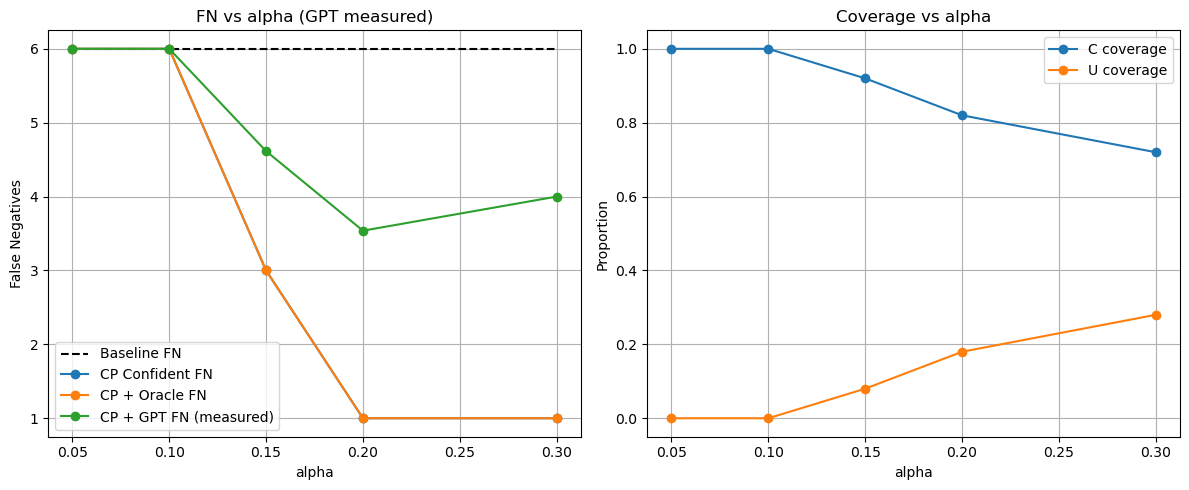

Saved figure to: /Users/jasondai/Desktop/uncertainty-aware-medAI/reports/figures/cp_fn_gpt_measured_bootstrap.png


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(df_cp["alpha"], df_cp["FN_baseline"], "--", color="black", label="Baseline FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_confident"], "o-", label="CP Confident FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_oracle"], "o-", label="CP + Oracle FN")
axes[0].plot(df_cp["alpha"], df_cp["FN_gpt_meas"], "o-", label="CP + GPT FN (measured)")

axes[0].set_title("FN vs alpha (GPT measured)")
axes[0].set_xlabel("alpha"); axes[0].set_ylabel("False Negatives")
axes[0].grid(True); axes[0].legend()

total = len(test)
axes[1].plot(df_cp["alpha"], df_cp["C_size"]/total, "o-", label="C coverage")
axes[1].plot(df_cp["alpha"], df_cp["U_size"]/total, "o-", label="U coverage")
axes[1].set_title("Coverage vs alpha")
axes[1].set_xlabel("alpha"); axes[1].set_ylabel("Proportion")
axes[1].grid(True); axes[1].legend()

plt.tight_layout()
out_path = FIG_DIR / "cp_fn_gpt_measured_bootstrap.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved figure to:", out_path)